In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

%matplotlib inline

Network Model

In [29]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer=nn.Sequential(
            nn.Linear(28*28+10,256,bias=True),
            nn.LeakyReLU(0.2),
            nn.Linear(256,256,bias=True),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1,bias=True),
            nn.Sigmoid()
        )
    
    def forward(self,x,y):
        x=torch.cat((x,y),1)        
        return self.layer(x)
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        self.layer=nn.Sequential(
            nn.Linear(110,256,bias=True),
            nn.ReLU(),
            nn.Linear(256,256,bias=True),
            nn.ReLU(),
            nn.Linear(256,28*28,bias=True),
            nn.Tanh()
        )
    def forward(self,x,y):
        x=torch.cat((x,y),1)
        return self.layer(x)

In [20]:
def to_onehot(label):    
    onehot=torch.zeros(len(label),10)
    eye=torch.eye(10)
    for i in range(len(label)):
        onehot[i]=eye[label[i]]
    return onehot

Train

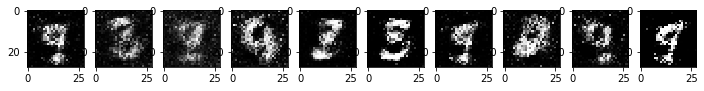

Epoch 0, Gen_cost = 1.371070900, Dis_cost = 1.098849346


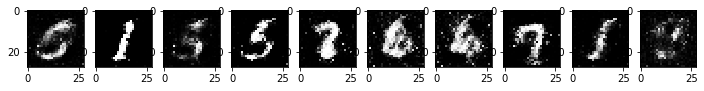

Epoch 1, Gen_cost = 1.555113502, Dis_cost = 1.010601277


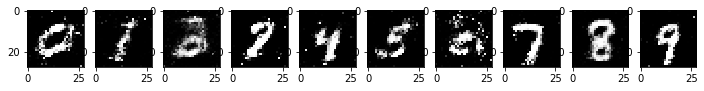

Epoch 2, Gen_cost = 1.246352324, Dis_cost = 1.111181461


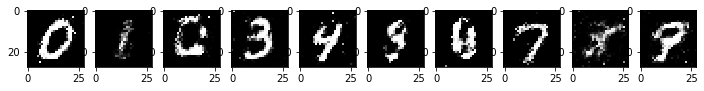

Epoch 3, Gen_cost = 1.132025450, Dis_cost = 1.170070051


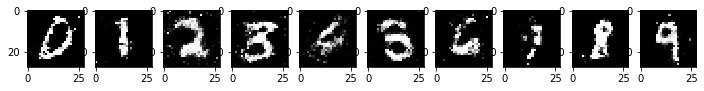

Epoch 4, Gen_cost = 1.068102153, Dis_cost = 1.203034072


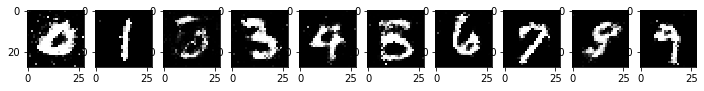

Epoch 5, Gen_cost = 1.030327345, Dis_cost = 1.224693623


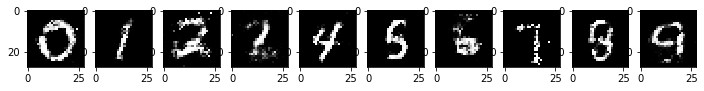

Epoch 6, Gen_cost = 0.979790426, Dis_cost = 1.246170728


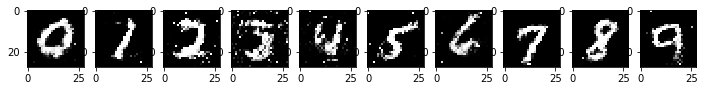

Epoch 7, Gen_cost = 0.971970736, Dis_cost = 1.253311588


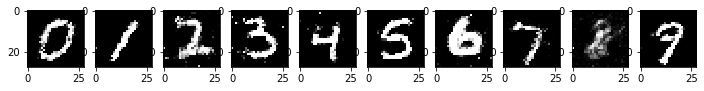

Epoch 8, Gen_cost = 0.962291957, Dis_cost = 1.254556475


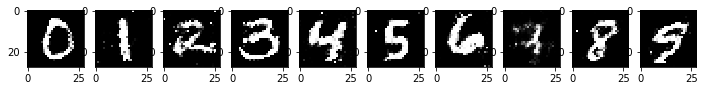

Epoch 9, Gen_cost = 0.961033214, Dis_cost = 1.255092891


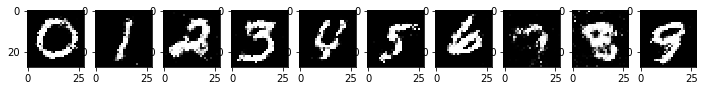

Epoch 10, Gen_cost = 0.952418216, Dis_cost = 1.262431603


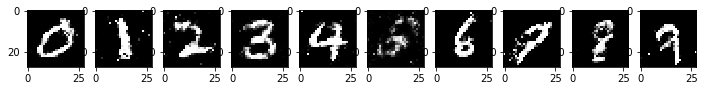

Epoch 11, Gen_cost = 0.955362169, Dis_cost = 1.258697771


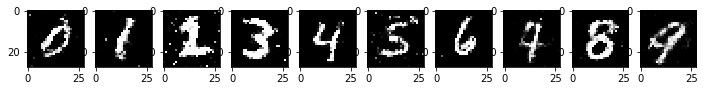

Epoch 12, Gen_cost = 0.958343334, Dis_cost = 1.255667197


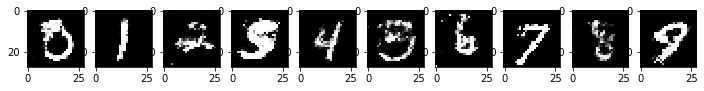

Epoch 13, Gen_cost = 0.959337007, Dis_cost = 1.250594385


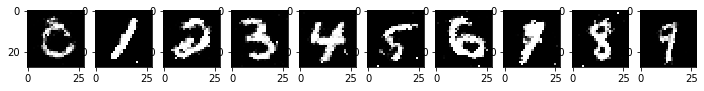

Epoch 14, Gen_cost = 0.966337464, Dis_cost = 1.251631205


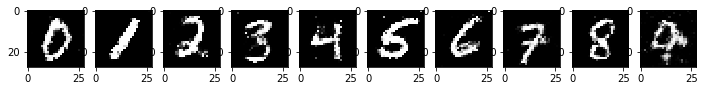

Epoch 15, Gen_cost = 0.975031808, Dis_cost = 1.242872212


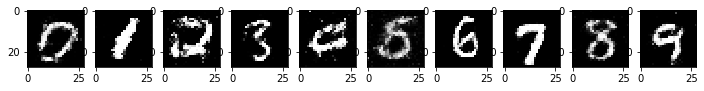

Epoch 16, Gen_cost = 0.990393077, Dis_cost = 1.235874413


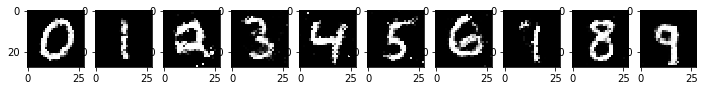

Epoch 17, Gen_cost = 0.998665527, Dis_cost = 1.227353745


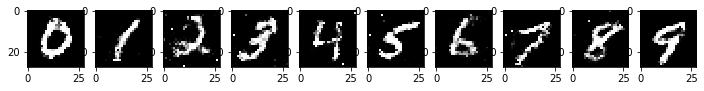

Epoch 18, Gen_cost = 0.998983127, Dis_cost = 1.225218744


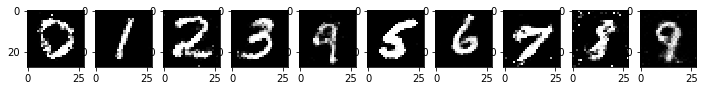

Epoch 19, Gen_cost = 0.997959822, Dis_cost = 1.229215264


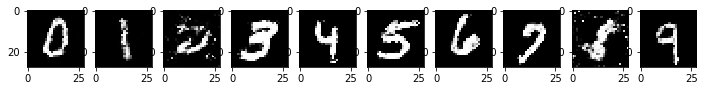

Epoch 20, Gen_cost = 1.006261738, Dis_cost = 1.226298406


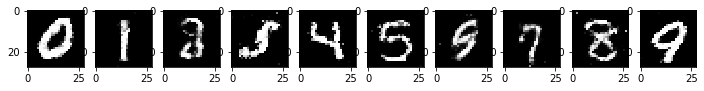

Epoch 21, Gen_cost = 1.004658535, Dis_cost = 1.223112399


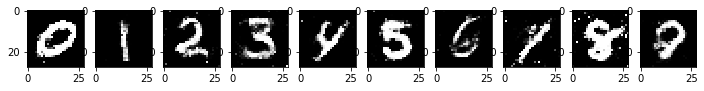

Epoch 22, Gen_cost = 1.007017516, Dis_cost = 1.223027448


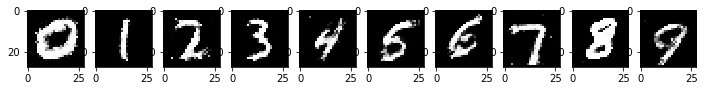

Epoch 23, Gen_cost = 1.012004021, Dis_cost = 1.223400955


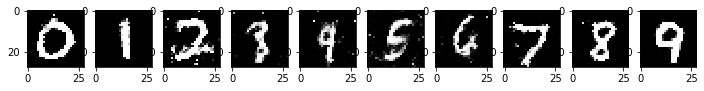

Epoch 24, Gen_cost = 1.024225761, Dis_cost = 1.222526138


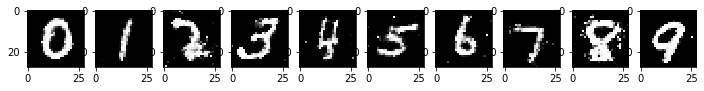

Epoch 25, Gen_cost = 1.011838469, Dis_cost = 1.217472309


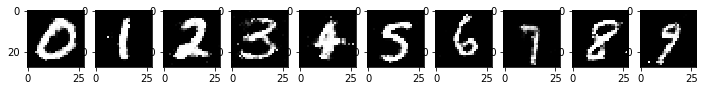

Epoch 26, Gen_cost = 1.029187751, Dis_cost = 1.212342142


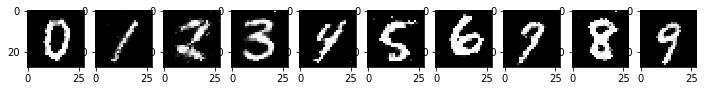

Epoch 27, Gen_cost = 1.032238242, Dis_cost = 1.208472775


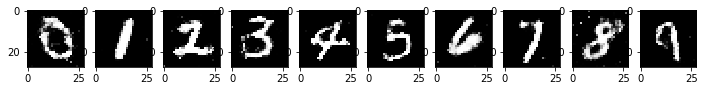

Epoch 28, Gen_cost = 1.030325055, Dis_cost = 1.208332944


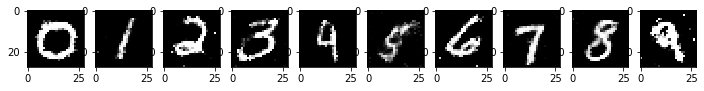

Epoch 29, Gen_cost = 1.044834049, Dis_cost = 1.204382396


In [35]:
device='cuda' if torch.cuda.is_available() else 'cpu'

trans=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])])

mnist_train=dsets.MNIST(root='MNIST_data/',train=True,transform=trans,download=True)
mnist_test=dsets.MNIST(root='MNIST_data/',train=False,transform=trans,download=True)

train_loader=DataLoader(dataset=mnist_train,shuffle=True,batch_size=64)

NetG=Generator().to(device)
NetD=Discriminator().to(device)

#NetG.load_state_dict(torch.load('param/GAN_G.pth'))
#NetD.load_state_dict(torch.load('param/GAN_D.pth'))

optim_G=optim.Adam(NetG.parameters(),lr=0.001,betas=(0.5,0.999))
optim_D=optim.Adam(NetD.parameters(),lr=0.001,betas=(0.5,0.999))

criterion=nn.BCELoss()

for epoch in range(30):
    avg_G,avg_D=0.0,0.0
    for X,Y in train_loader:
        X,Y=X.view(X.size(0),-1).to(device),to_onehot(Y).to(device)
        
        real_label=torch.ones(X.size(0),1).to(device)
        fake_label=torch.zeros(X.size(0),1).to(device)        
        rand=torch.randn(X.size(0),100).to(device)
        
        ### Discriminator Loss ###        
        real_output=NetD(X,Y)
        fake_output=NetD(NetG(rand,Y),Y)
        
        cost_D_Real=criterion(real_output,real_label)
        cost_D_Fake=criterion(fake_output,fake_label)
                              
        cost_D=cost_D_Real+cost_D_Fake
        
        optim_D.zero_grad()
        cost_D.backward()        
        optim_D.step()        
        
        ### Generator Loss ###
        rand=torch.randn(X.size(0),100).to(device)
        Gen_img=NetG(rand,Y)      
        
        cost_G=criterion(NetD(Gen_img,Y),real_label)
        
        optim_G.zero_grad()
        cost_G.backward()        
        optim_G.step()
        
        avg_D+=cost_D.item()
        avg_G+=cost_G.item()
    
    with torch.no_grad():
        rand=torch.randn(10,100).to(device)
        Y_test=torch.LongTensor([i for i in range(10)])
        Y_test=to_onehot(Y_test).to(device)

        predict=NetG(rand,Y_test)

        fig,(axes)=plt.subplots(1,10,figsize=(12,12))
        for i,ax in enumerate(axes):
            ax.imshow(predict[i].view(28,28).detach().cpu().numpy(),cmap='gray')
        plt.show()
        
    avg_D/=len(train_loader)
    avg_G/=len(train_loader)
    torch.save(NetG.state_dict(),'param/GAN_G.pth')
    torch.save(NetD.state_dict(),'param/GAN_D.pth')
    print('Epoch {}, Gen_cost = {:.9f}, Dis_cost = {:.9f}'.format(epoch,avg_G,avg_D))